In [1]:
import sys, os
sys.path.insert(0, '/home/niell_lab/Documents/github/FreelyMovingEphys/')
from projects.ephys.population import Population
import pandas as pd
from src.utils.path import find
from src.utils.auxiliary import flatten_series
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.gridspec as gridspec

In [2]:
mpl.rcParams.update({'font.size': 25})
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [3]:
%matplotlib inline

In [4]:
hffm_savepath = '/home/niell_lab/data/freely_moving_ephys/batch_files/021022/hffm'
hffm = Population(savepath=hffm_savepath)
hffm.load(fname='hffm_pop2')

reading from /home/niell_lab/data/freely_moving_ephys/batch_files/021022/hffm/hffm_pop2.pickle


In [5]:
hffm.add_avalible_RcSn_psth()

reading /home/niell_lab/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/062921/G6HCK1ALTRN/addtlhf_props.npz
reading /home/niell_lab/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/070921/J553RT/addtlhf_props.npz
reading /home/niell_lab/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/101521/J559NC/addtlhf_props.npz
reading /home/niell_lab/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/102621/J558NC/addtlhf_props.npz
reading /home/niell_lab/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/110321/J558LT/addtlhf_props.npz
reading /home/niell_lab/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/110421/J569LT/addtlhf_props.npz
reading /home/niell_lab/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/122021/J581RT/addtlhf_props.npz
reading /home/niell_lab/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/020222/J577TT/addtlhf_props.npz
reading /home/niell_lab/Goeppert/nlab-nas/Dylan/freely_movi

In [6]:
hffm.save(fname='hffm_pop2')

saving to /home/niell_lab/data/freely_moving_ephys/batch_files/021022/hffm/hffm_pop2.pickle


In [14]:
hffm.data['session'].unique()

array(['062921_G6HCK1ALTRN_control_Rig2', '070921_J553RT_control_Rig2',
       '101521_J559NC_control_Rig2', '102621_J558NC_control_Rig2',
       '110321_J558LT_control_Rig2', '110421_J569LT_control_Rig2',
       '122021_J581RT_control_Rig2', '020222_J577TT_control_Rig2',
       '020422_J577RT_control_Rig2'], dtype=object)

In [134]:
def movement_psth(panel, row, rightname, legend=False):
    leftname = rightname.replace('right','left')
    panel.plot(hffm.trange_x, row[rightname], color=hffm.cmap_sacc[0], label='right')
    panel.plot(hffm.trange_x, row[leftname], color=hffm.cmap_sacc[1], label='left')
    panel.set_ylim([0, np.max(np.maximum(row[rightname], row[leftname]))*1.2])
    panel.set_xlim([-0.2, 0.4])
    panel.set_ylabel('sp/sec')
    panel.set_xlabel('sec')
    if legend:
        panel.legend(loc=9, ncol=2)

In [64]:
def plot_flow_vec(panel, movstate, row):
    fv = row['FmLt_optic_flow_'+movstate+'_vec'].astype(float) # shape is [x, y, U/V]

    nx = 5
    fv_scale = row['FmLt_flowvec_scale']
    flow_w = np.size(fv, 1)
    flow_h = np.size(fv, 0)

    X,Y = np.meshgrid(np.arange(0,flow_w),np.arange(0,flow_h))
    U = fv[:,:,0]; V = fv[:,:,1]

    panel.quiver(X[::nx,::nx], -Y[::nx,::nx], U[::nx,::nx], -V[::nx,::nx], scale=fv_scale)
    panel.axis('off')
    panel.axis('equal')

In [88]:
def wrap_tuning(vals):
    vals = vals.flatten()
    return np.hstack([vals, vals[0]])

In [100]:
def modind(a, b):
    """
    value of 1 means a is more significant
    value of -1 means b is more significant
    """
    mi = (a - b) / (a + b)
    return mi

In [106]:
for ind, row in hffm.data[hffm.data['fr']>2].iterrows():
    if row['movcluster'] in ['early','late','biphasic','negative']:
        pref_gaze = row['pref_gazeshift_psth'][hffm.trange_win[0]:hffm.trange_win[1]]
        nonpref_gaze = row['nonpref_gazeshift_psth'][hffm.trange_win[0]:hffm.trange_win[1]]
        pref_comp = row['pref_comp_psth'][hffm.trange_win[0]:hffm.trange_win[1]]
        nonpref_comp= row['nonpref_comp_psth'][hffm.trange_win[0]:hffm.trange_win[1]]
        
        if row['pref_gazeshift_direction']=='L':
            left_gaze = pref_gaze; right_gaze = nonpref_gaze
            left_comp = pref_comp; right_comp = nonpref_comp
        elif row['pref_gazeshift_direction']=='R':
            right_gaze = pref_gaze; left_gaze = nonpref_gaze
            right_comp = pref_comp; left_comp = nonpref_comp
        
        hffm.data.at[ind, 'gaze_sacc_rlMI'] = modind(np.max(right_gaze), np.max(left_gaze))
        hffm.data.at[ind, 'comp_sacc_rlMI'] = modind(np.max(right_comp), np.max(left_comp))
        hffm.data.at[ind, 'gaze_sacc_pnpMI'] = modind(np.max(pref_gaze), np.max(nonpref_gaze))
        hffm.data.at[ind, 'comp_sacc_pnpMI'] = modind(np.max(pref_comp), np.max(nonpref_comp))
        
    if row['responsive_to_gratings']:
        ori = row['Gt_ori_tuning_mean_tf']
        best_sf = ori[:,np.argmax(np.mean(ori,0))]
        left_grat = best_sf[0]
        right_grat = best_sf[4]
        hffm.data.at[ind, 'gratings_rlMI'] = modind(right_grat, left_grat)

In [124]:
def direcpref_scatter_c(panel, xname, yname):
    for i in range(4):
        name = ['early','late','biphasic','negative'][i]
        x_mi = hffm.data[xname][hffm.data['movcluster']==name]
        y_mi = hffm.data[yname][hffm.data['movcluster']==name]
        panel.plot(x_mi, y_mi, '.', color=hffm.cmap_movclusts[i+1], markersize=6)
    panel.vlines(0,-1,1,linestyle='dotted',alpha=0.5, colors='k')
    panel.hlines(0,-1,1,linestyle='dotted',alpha=0.5, colors='k')

In [125]:
page = 91
row = hffm.data.iloc[page]

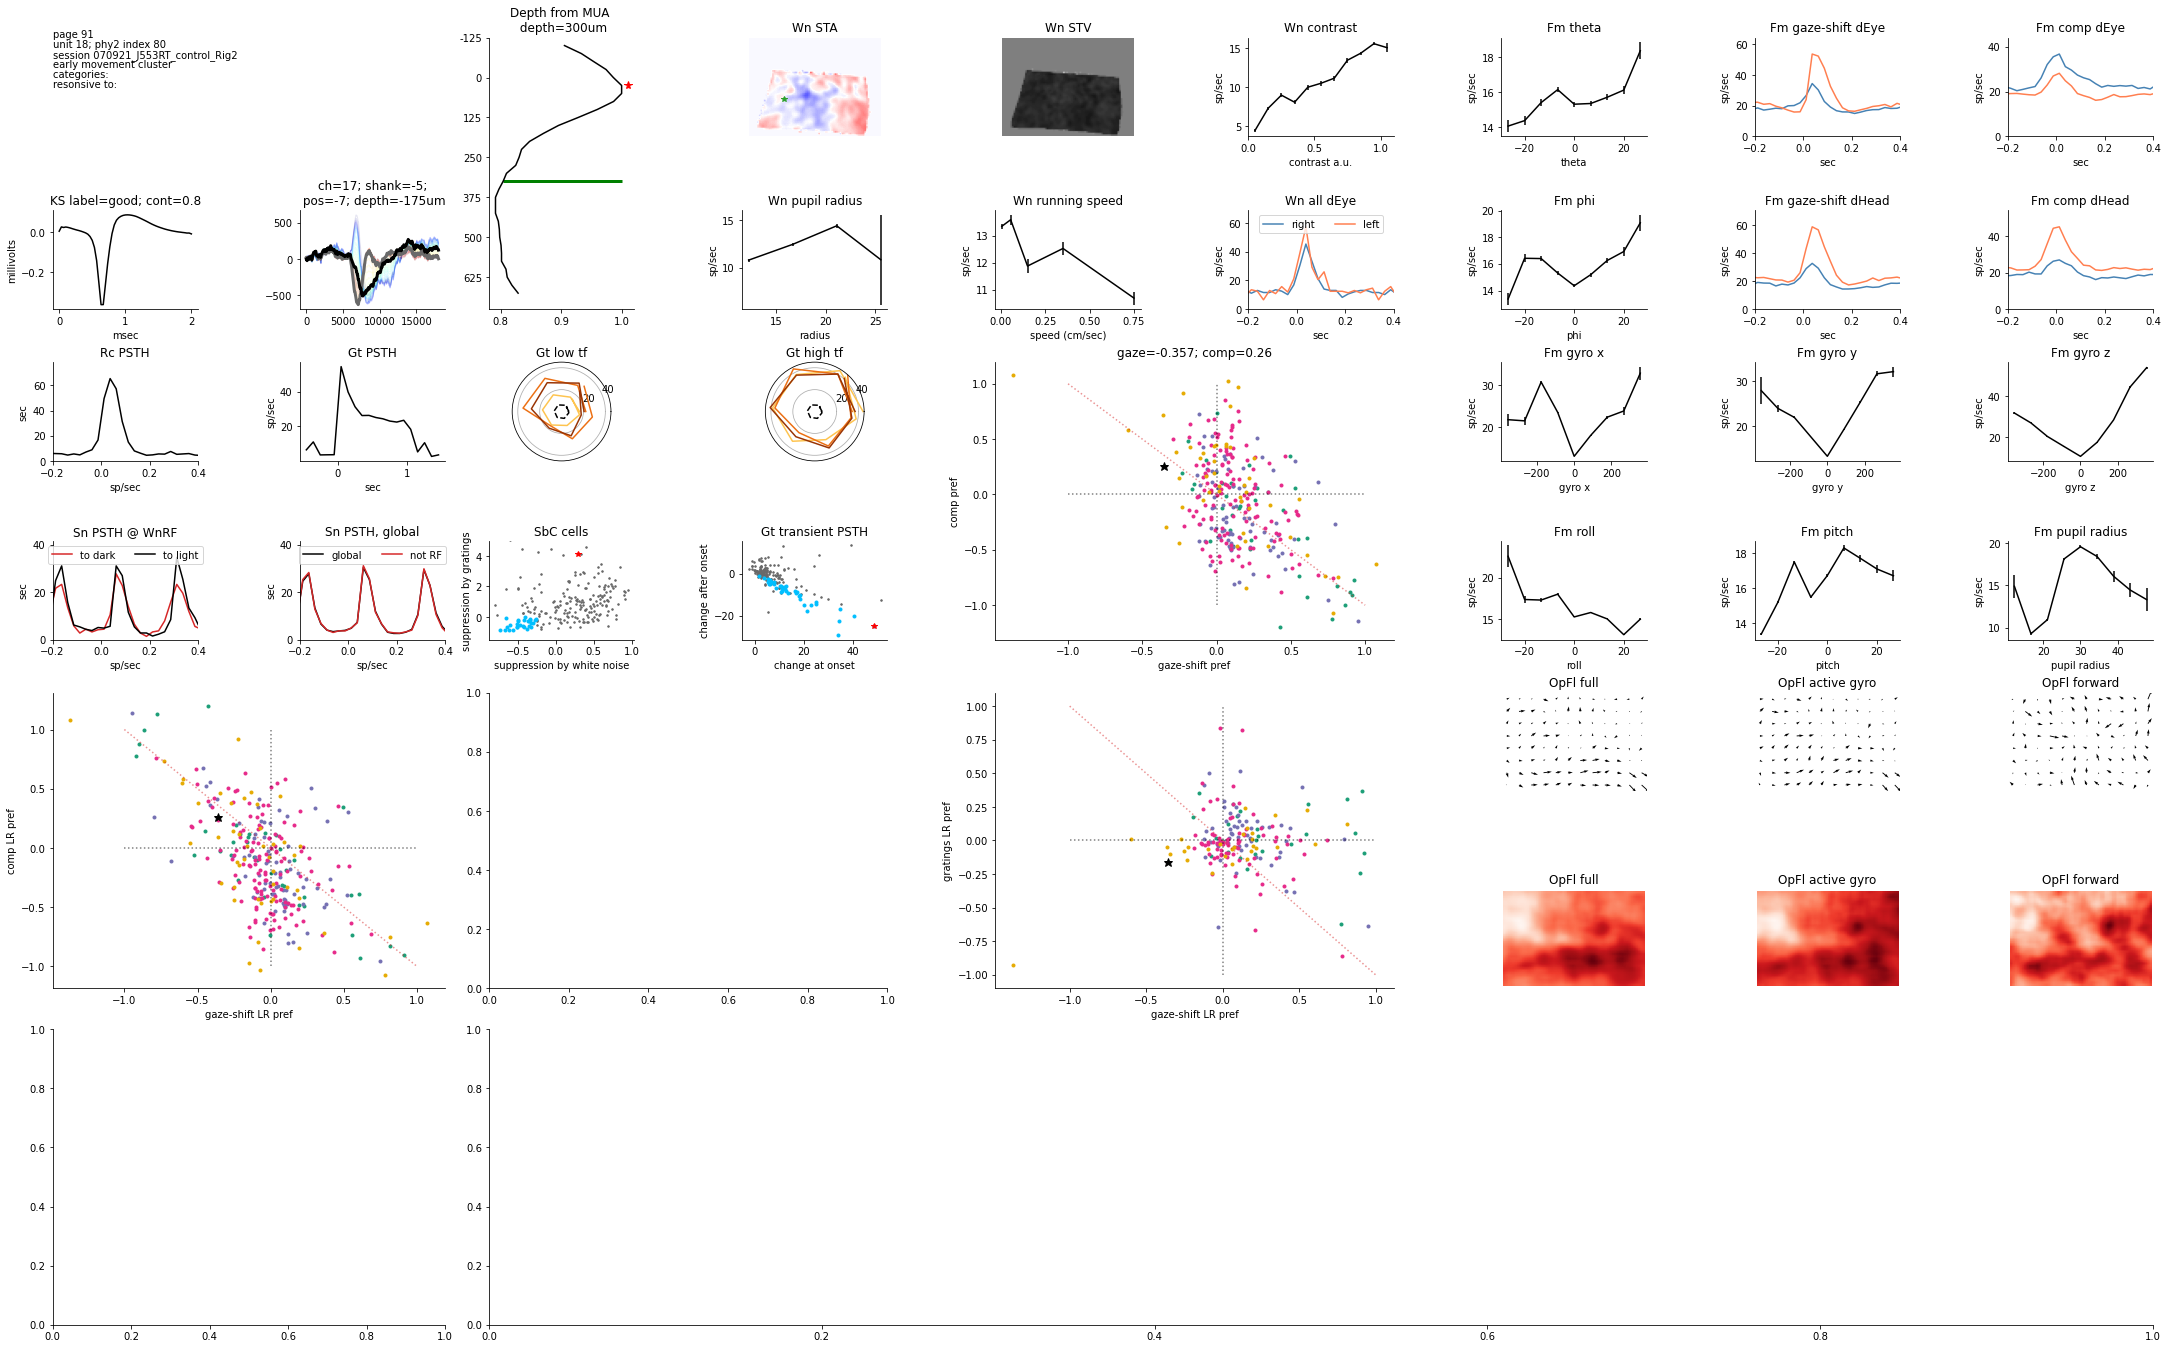

In [135]:
fig = plt.figure(constrained_layout=True, figsize=(30,20))
spec = gridspec.GridSpec(nrows=9, ncols=9, figure=fig)

ax_text = fig.add_subplot(spec[0,0:2])
ax_spwvfrm = fig.add_subplot(spec[1,0])
ax_Rc_depth = fig.add_subplot(spec[1,1])
ax_MUA_depth = fig.add_subplot(spec[0:2,2])

ax_Wn_STA = fig.add_subplot(spec[0,3])
ax_Wn_STV = fig.add_subplot(spec[0,4])
ax_Wn_tuning = fig.add_subplot(spec[0,5])
ax_Wn_pupilrad = fig.add_subplot(spec[1,3])
ax_Wn_speed = fig.add_subplot(spec[1,4])
ax_Wn_sacc = fig.add_subplot(spec[1,5])

ax_Rc_psth = fig.add_subplot(spec[2,0])
ax_Sn_psth_rf = fig.add_subplot(spec[3,0])
ax_Sn_psth_gb = fig.add_subplot(spec[3,1])

ax_Gt_psth = fig.add_subplot(spec[2,1])
ax_Gt_polar_ltf = fig.add_subplot(spec[2,2], projection='polar')
ax_Gt_polar_htf = fig.add_subplot(spec[2,3], projection='polar')

ax_theta = fig.add_subplot(spec[0,6])
ax_phi = fig.add_subplot(spec[1,6])
ax_gyrox = fig.add_subplot(spec[2,6])
ax_gyroy = fig.add_subplot(spec[2,7])
ax_gyroz = fig.add_subplot(spec[2,8])
ax_roll = fig.add_subplot(spec[3,6])
ax_pitch = fig.add_subplot(spec[3,7])
ax_Fm_pupilrad = fig.add_subplot(spec[3,8])
ax_Fm_sacc_gaze_dEye = fig.add_subplot(spec[0,7])
ax_Fm_sacc_comp_dEye = fig.add_subplot(spec[0,8])
ax_Fm_sacc_gaze_dHead = fig.add_subplot(spec[1,7])
ax_Fm_sacc_comp_dHead = fig.add_subplot(spec[1,8])
ax_full_opfl_vec = fig.add_subplot(spec[4,6])
ax_gyro_opfl_vec = fig.add_subplot(spec[4,7])
ax_top_opfl_vec = fig.add_subplot(spec[4,8])
ax_full_opfl_amp = fig.add_subplot(spec[5,6])
ax_gyro_opfl_amp = fig.add_subplot(spec[5,7])
ax_top_opfl_amp = fig.add_subplot(spec[5,8])

ax_SbC = fig.add_subplot(spec[3,2])
ax_tr_grat = fig.add_subplot(spec[3,3])
ax_PNP_gaze_comp = fig.add_subplot(spec[2:4,4:6])
ax_LR_gaze_comp = fig.add_subplot(spec[4:6,0:2])
ax_LR_gaze_opfl = fig.add_subplot(spec[4:6,2:4])
ax_LR_gaze_grat = fig.add_subplot(spec[4:6,4:6])
ax_LR_opfl_grat = fig.add_subplot(spec[6:8,0:2])
ax_bars = fig.add_subplot(spec[6:8,2:])

ax_text.axis('off')
ind_in_session = int(np.argwhere(hffm.data[hffm.data['session']==row['session']].index.values==page).flatten())
ax_text.annotate('page {}'.format(page), color='k', xy=[0,0])
ax_text.annotate('unit {}; phy2 index {}'.format(ind_in_session, row['index']), color='k', xy=[0,1])
ax_text.annotate('session {}'.format(row['session']), color='k', xy=[0,2])
ax_text.annotate('{} movement cluster'.format(row['movcluster']), color='k', xy=[0,3])
otherprops = []; responsive_to = []
if row['is_SbC']:
    otherprops.append('Wn SbC')
if row['is_grat_trpsth']:
    otherprops.append('Gt transient ')
if row['responsive_to_gratings']:
    responsive_to.append('Gt')
if row['responsive_to_contrast']:
    responsive_to.append('Wn')
ax_text.annotate('categories: '.format(otherprops), color='k', xy=[0,4])
ax_text.annotate('resonsive to: '.format(responsive_to), color='k', xy=[0,5])
ax_text.set_ylim([10,0])

ax_spwvfrm.plot(np.arange(len(row['waveform']))*1000/hffm.samprate, row['waveform'], color='k')
ax_spwvfrm.set_ylabel('millivolts'); ax_spwvfrm.set_xlabel('msec')
ax_spwvfrm.set_title('KS label={}; cont={:3}'.format(row['KSLabel'], row['ContamPct']))

cmap_Rc_depth = plt.cm.jet(np.linspace(0,1,32))
shank_num = int(np.floor(int(row['ch'])/32))
shank_channels = [c for c in range(np.size(row['Rc_response_by_channel'], 0)) if int(np.floor(c/32)) == int(np.floor(int(row['ch'])/32))]
whole_shank = row['Rc_response_by_channel'][shank_channels]
for ch_num in range(len(shank_channels)):
    ax_Rc_depth.plot(whole_shank[ch_num], color=cmap_Rc_depth[ch_num], alpha=0.1, linewidth=1) # all other channels
ax_Rc_depth.plot(whole_shank[row['Rc_layer4cent'][shank_num]], color='dimgray', label='layer4', linewidth=3) # layer 4
ax_Rc_depth.plot(row['Rc_response_by_channel'][row['ch']%32], color='k', label='this channel', linewidth=3)
ax_Rc_depth.set_title('ch={}; shank={};\n pos={}; depth={}um'.format(row['ch'], int(row['Rc_relative_depth'][1][row['ch']-([0, 32, 64, 96][shank_num])]), int(row['Rc_relative_depth'][shank_num][row['ch']%32]), int(row['Rc_depth_from_layer4'])))

ax_MUA_depth.hlines(y=row['ch']%32, xmin=row['Wn_lfp_power'][shank_num][int(row['ch']%32)], xmax=1, colors='g', linewidth=3)
ax_MUA_depth.set_ylim([33,-1])
ax_MUA_depth.set_yticks(list(range(-1,32+1,5)))
ax_MUA_depth.set_yticklabels(25*np.arange(0,32+2,5)-(row['Wn_layer5cent_from_lfp'][shank_num]*25))
ax_MUA_depth.plot(row['Wn_lfp_power'][shank_num],range(0,32),color='k')
ax_MUA_depth.plot(row['Wn_lfp_power'][shank_num][row['Wn_layer5cent_from_lfp'][shank_num]]+0.01, row['Wn_layer5cent_from_lfp'][shank_num],'r*',markersize=8)
ax_MUA_depth.set_title('Depth from MUA \n depth={:0}um'.format(25*(row['ch']%32)-(row['Wn_layer5cent_from_lfp'][shank_num]*25)))

sta_range = np.max(np.abs(row['Wn_spike_triggered_average']))*1.2
sta_range = (0.25 if sta_range<0.25 else sta_range)
ax_Wn_STA.imshow(row['Wn_spike_triggered_average'], vmin=-sta_range, vmax=sta_range, cmap='seismic')
ax_Wn_STA.set_title('Wn STA')
ax_Wn_STA.axis('off')
ax_Wn_STA.plot(row['Wn_rf_cent'][0]/2, row['Wn_rf_cent'][1]/2, '*', color='tab:green')


sta_range = np.max(np.abs(row['Wn_spike_triggered_variance']))*1.2
sta_range = (0.25 if sta_range<0.25 else sta_range)
ax_Wn_STV.imshow(row['Wn_spike_triggered_variance'], vmin=-sta_range, vmax=sta_range, cmap='binary')
ax_Wn_STV.set_title('Wn STV')
ax_Wn_STV.axis('off')

ax_Wn_tuning.set_title('Wn contrast')
ax_Wn_tuning.errorbar(row['Wn_contrast_tuning_bins'], row['Wn_contrast_tuning'], yerr=row['Wn_contrast_tuning_err'], color='k')
ax_Wn_tuning.set_ylabel('sp/sec')
ax_Wn_tuning.set_xlabel('contrast a.u.')

ax_Wn_pupilrad.set_title('Wn pupil radius')
ax_Wn_pupilrad.errorbar(row['Wn_pupilradius_tuning_bins'], row['Wn_pupilradius_tuning'], yerr=row['Wn_pupilradius_tuning_err'], color='k')
ax_Wn_pupilrad.set_ylabel('sp/sec')
ax_Wn_pupilrad.set_xlabel('radius')

ax_Wn_speed.set_title('Wn running speed')
ax_Wn_speed.errorbar(row['Wn_ballspeed_tuning_bins'], row['Wn_ballspeed_tuning'], yerr=row['Wn_ballspeed_tuning_err'], color='k')
ax_Wn_speed.set_ylabel('sp/sec')
ax_Wn_speed.set_xlabel('speed (cm/sec)')

movement_psth(ax_Wn_sacc, row, 'Wn_rightsacc_avg', legend=True)
ax_Wn_sacc.set_title('Wn all dEye')


ax_Rc_psth.plot(hffm.trange_x, row['Rc_psth'], color='k')
ax_Rc_psth.set_ylim([0,np.nanmax(row['Rc_psth'])*1.2])
ax_Rc_psth.set_title('Rc PSTH')
ax_Rc_psth.set_ylabel('sec')
ax_Rc_psth.set_xlabel('sp/sec')
ax_Rc_psth.set_xlim([-0.2,0.4])

ax_Sn_psth_rf.plot(hffm.trange_x, row['Sn_l2d_psth'], color='tab:red', label='to dark')
ax_Sn_psth_rf.plot(hffm.trange_x, row['Sn_d2l_psth'], color='k', label='to light')
ax_Sn_psth_rf.set_ylim([0,np.nanmax(np.concatenate([row['Sn_l2d_psth'],row['Sn_d2l_psth']]))*1.2])
ax_Sn_psth_rf.set_title('Sn PSTH @ WnRF')
ax_Sn_psth_rf.set_ylabel('sec')
ax_Sn_psth_rf.set_xlabel('sp/sec')
ax_Sn_psth_rf.set_xlim([-0.2,0.4])
ax_Sn_psth_rf.legend(loc=9, ncol=2)

ax_Sn_psth_gb.plot(hffm.trange_x, row['Sn_all_psth'], color='k', label='global')
ax_Sn_psth_gb.plot(hffm.trange_x, row['Sn_onlyglobal_psth'], color='tab:red', label='not RF')
ax_Sn_psth_gb.set_ylim([0,np.nanmax(np.concatenate([row['Sn_l2d_psth'],row['Sn_d2l_psth']]))*1.2])
ax_Sn_psth_gb.set_title('Sn PSTH, global')
ax_Sn_psth_gb.set_ylabel('sec')
ax_Sn_psth_gb.set_xlabel('sp/sec')
ax_Sn_psth_gb.set_xlim([-0.2,0.4])
ax_Sn_psth_gb.legend(loc=9, ncol=2)
    
ax_Gt_psth.plot(hffm.grat_psth_x, row['Gt_grating_psth'], 'k')
ax_Gt_psth.set_title('Gt PSTH')
ax_Gt_psth.set_ylabel('sp/sec')
ax_Gt_psth.set_xlabel('sec')

for tf, panel in enumerate([ax_Gt_polar_ltf, ax_Gt_polar_htf]):
    for sf in range(3):
        panel.plot(np.arange(8)*45, row['Gt_ori_tuning_tf'][:,sf,tf], color=hffm.cmap_orientation[sf])
    panel.plot(np.arange(8)*45, np.ones(8)*row['Gt_drift_spont'], linestyle='dashed', color=hffm.cmap_orientation[3])
    panel.set_xticks([])
    panel.set_ylim(*[0,np.max(row['Gt_ori_tuning_tf'])])

ax_Gt_polar_ltf.set_title('Gt low tf')
ax_Gt_polar_htf.set_title('Gt high tf')

ax_theta.set_title('Fm theta')
ax_theta.errorbar(row['FmLt_theta_tuning_bins'], row['FmLt_theta_tuning'], yerr=row['FmLt_theta_tuning_err'], color='k')
ax_theta.set_ylabel('sp/sec')
ax_theta.set_xlabel('theta')

ax_phi.set_title('Fm phi')
ax_phi.errorbar(row['FmLt_phi_tuning_bins'], row['FmLt_phi_tuning'], yerr=row['FmLt_phi_tuning_err'], color='k')
ax_phi.set_ylabel('sp/sec')
ax_phi.set_xlabel('phi')

ax_gyrox.set_title('Fm gyro x')
ax_gyrox.errorbar(row['FmLt_gyrox_tuning_bins'], row['FmLt_gyrox_tuning'], yerr=row['FmLt_gyrox_tuning_err'], color='k')
ax_gyrox.set_ylabel('sp/sec')
ax_gyrox.set_xlabel('gyro x')

ax_gyroy.set_title('Fm gyro y')
ax_gyroy.errorbar(row['FmLt_gyroy_tuning_bins'], row['FmLt_gyroy_tuning'], yerr=row['FmLt_gyroy_tuning_err'], color='k')
ax_gyroy.set_ylabel('sp/sec')
ax_gyroy.set_xlabel('gyro y')

ax_gyroz.set_title('Fm gyro z')
ax_gyroz.errorbar(row['FmLt_gyroz_tuning_bins'], row['FmLt_gyroz_tuning'], yerr=row['FmLt_gyroz_tuning_err'], color='k')
ax_gyroz.set_ylabel('sp/sec')
ax_gyroz.set_xlabel('gyro z')

ax_roll.set_title('Fm roll')
ax_roll.errorbar(row['FmLt_roll_tuning_bins'], row['FmLt_roll_tuning'], yerr=row['FmLt_roll_tuning_err'], color='k')
ax_roll.set_ylabel('sp/sec')
ax_roll.set_xlabel('roll')

ax_pitch.set_title('Fm pitch')
ax_pitch.errorbar(row['FmLt_pitch_tuning_bins'], row['FmLt_pitch_tuning'], yerr=row['FmLt_pitch_tuning_err'], color='k')
ax_pitch.set_ylabel('sp/sec')
ax_pitch.set_xlabel('pitch')

ax_Fm_pupilrad.set_title('Fm pupil radius')
ax_Fm_pupilrad.errorbar(row['FmLt_pupilradius_tuning_bins'], row['FmLt_pupilradius_tuning'], yerr=row['FmLt_pupilradius_tuning_err'], color='k')
ax_Fm_pupilrad.set_ylabel('sp/sec')
ax_Fm_pupilrad.set_xlabel('pupil radius')

movement_psth(ax_Fm_sacc_gaze_dEye, row, 'FmLt_rightsacc_avg_gaze_shift_dEye')
ax_Fm_sacc_gaze_dEye.set_title('Fm gaze-shift dEye')

movement_psth(ax_Fm_sacc_comp_dEye, row, 'FmLt_rightsacc_avg_comp_dEye')
ax_Fm_sacc_comp_dEye.set_title('Fm comp dEye')

movement_psth(ax_Fm_sacc_gaze_dHead, row, 'FmLt_rightsacc_avg_gaze_shift_dHead')
ax_Fm_sacc_gaze_dHead.set_title('Fm gaze-shift dHead')

movement_psth(ax_Fm_sacc_comp_dHead, row, 'FmLt_rightsacc_avg_comp_dHead')
ax_Fm_sacc_comp_dHead.set_title('Fm comp dHead')

plot_flow_vec(ax_full_opfl_vec, 'full', row)
ax_full_opfl_vec.set_title('OpFl full')

plot_flow_vec(ax_gyro_opfl_vec, 'active_gyro', row)
ax_gyro_opfl_vec.set_title('OpFl active gyro')

plot_flow_vec(ax_top_opfl_vec, 'running_forward', row)
ax_top_opfl_vec.set_title('OpFl forward')

ax_full_opfl_amp.imshow(row['FmLt_optic_flow_full_amp'].astype(float), cmap='Reds')
ax_full_opfl_amp.axis('off')
ax_full_opfl_amp.axis('equal')
ax_full_opfl_amp.set_title('OpFl full')

ax_gyro_opfl_amp.imshow(row['FmLt_optic_flow_active_gyro_amp'].astype(float), cmap='Reds')
ax_gyro_opfl_amp.axis('off')
ax_gyro_opfl_amp.axis('equal')
ax_gyro_opfl_amp.set_title('OpFl active gyro')

ax_top_opfl_amp.imshow(row['FmLt_optic_flow_running_forward_amp'].astype(float), cmap='Reds')
ax_top_opfl_amp.axis('off')
ax_top_opfl_amp.axis('equal')
ax_top_opfl_amp.set_title('OpFl forward')

SBCs = hffm.data[hffm.data['is_SbC']]
ax_SbC.plot(-hffm.data['SbC_min_mid_mod'][hffm.data['responsive_to_contrast']][hffm.data['is_SbC']==False],
                  hffm.data['grat_psth_drop'][hffm.data['responsive_to_contrast']][hffm.data['is_SbC']==False],
                  '.', color=hffm.cmap_special2[0], markersize=3)
ax_SbC.plot(-SBCs['SbC_min_mid_mod'], SBCs['grat_psth_drop'], '.', color=hffm.cmap_special2[1], markersize=6)
ax_SbC.plot(-row['SbC_min_mid_mod'], row['grat_psth_drop'], 'r*', markersize=6)
ax_SbC.set_ylim([-1.5,5])
ax_SbC.set_title('SbC cells')
ax_SbC.set_ylabel('suppression by gratings')
ax_SbC.set_xlabel('suppression by white noise')

trPsth = hffm.data[hffm.data['is_grat_trpsth']][hffm.data['responsive_to_gratings']]
sPsth = hffm.data[hffm.data['responsive_to_gratings']][hffm.data['is_grat_trpsth']==False]
ax_tr_grat.plot(sPsth['change_at_gratstim_onset'], sPsth['change_during_gratstim'], '.', color=hffm.cmap_special2[0], markersize=3)
ax_tr_grat.plot(trPsth['change_at_gratstim_onset'], trPsth['change_during_gratstim'], '.', color=hffm.cmap_special2[1], markersize=6)
ax_tr_grat.plot(row['change_at_gratstim_onset'], row['change_during_gratstim'], 'r*', markersize=6)
ax_tr_grat.set_ylabel('change after onset')
ax_tr_grat.set_xlabel('change at onset')
ax_tr_grat.set_title('Gt transient PSTH')

direcpref_scatter_c(ax_PNP_gaze_comp, 'gaze_sacc_pnpMI', 'comp_sacc_pnpMI')
ax_PNP_gaze_comp.plot(row['gaze_sacc_pnpMI'], row['comp_sacc_pnpMI'], 'k*', markersize=9)
ax_PNP_gaze_comp.set_ylabel('comp pref')
ax_PNP_gaze_comp.set_xlabel('gaze-shift pref')
ax_PNP_gaze_comp.plot([-1,1],[1,-1],linestyle='dotted',alpha=0.5, color='tab:red')
ax_PNP_gaze_comp.set_title('gaze={:.3}; comp={:.3}'.format(row['gaze_sacc_pnpMI'], row['comp_sacc_pnpMI']))

direcpref_scatter_c(ax_LR_gaze_comp, 'gaze_sacc_rlMI', 'comp_sacc_rlMI')
ax_LR_gaze_comp.plot(row['gaze_sacc_rlMI'], row['comp_sacc_rlMI'], 'k*', markersize=9)
ax_LR_gaze_comp.set_ylabel('comp LR pref')
ax_LR_gaze_comp.set_xlabel('gaze-shift LR pref')
ax_LR_gaze_comp.plot([-1,1],[1,-1],linestyle='dotted',alpha=0.5, color='tab:red')

direcpref_scatter_c(ax_LR_gaze_grat, 'gaze_sacc_pnpMI', 'gratings_rlMI')
ax_LR_gaze_grat.plot(row['gaze_sacc_pnpMI'], row['gratings_rlMI'], 'k*', markersize=9)
ax_LR_gaze_grat.set_ylabel('gratings LR pref')
ax_LR_gaze_grat.set_xlabel('gaze-shift LR pref')
ax_LR_gaze_grat.plot([-1,1],[1,-1],linestyle='dotted',alpha=0.5, color='tab:red')

ax_bars

# direcpref_scatter_c(ax_PNP_gaze_comp, 'gaze_sacc_pnpMI', 'comp_sacc_pnpMI')
# ax_PNP_gaze_comp.plot(row['gaze_sacc_pnpMI'], row['comp_sacc_pnpMI'], 'k*', markersize=9)
# ax_PNP_gaze_comp.set_ylabel('comp pref')
# ax_PNP_gaze_comp.set_xlabel('gaze-shift pref')
# ax_PNP_gaze_comp.plot([-1,1],[1,-1],linestyle='dotted',alpha=0.5, color='tab:red')

# ax_LR_gaze_opfl = fig.add_subplot(spec[4:6,2:4])
# ax_LR_opfl_grat = fig.add_subplot(spec[6:8,0:2])
# ax_bars = fig.add_subplot(spec[6:8,2:])

In [ ]:
fig, ax = subplot(111)
for i, name in enumerate(['osi_for_sf_pref','dsi_for_sf_pref','sf_pref_cpd', ])
plt.bar(i)

In [74]:
row['Gt_ori_tuning_tf'][:,sf,tf].flatten()

array([16.3939273 , 15.42823488, 17.0138204 , 17.4697812 , 15.38317259,
       13.69923807, 16.6656588 , 14.86927755])

In [70]:
(np.arange(9)*45).shape

(9,)

In [91]:
row['Gt_ori_tuning_tf'][:,sf,tf]

array([36.86818042, 40.18641923, 37.16865599, 40.8602789 , 28.74638684,
       35.7796716 , 34.50916988, 40.48762284])

In [92]:
wrap_tuning(row['Gt_ori_tuning_tf'][:,sf,tf])

array([36.86818042, 40.18641923, 37.16865599, 40.8602789 , 28.74638684,
       35.7796716 , 34.50916988, 40.48762284, 36.86818042])

In [ ]:


def optic_flow_amp(self, panel, movstate):
    fa = self.current_row['FmLt_optic_flow_'+movstate+'_amp'].astype(float) # shape is [x, y]

    panel.imshow(fa, cmap='Reds')
    panel.axis('off')
    panel.axis('equal')
    # panel.set_title(movstate + ' amp')